In [ ]:
import warnings
# Ignore numpy dtype warnings. These warnings are caused by an interaction
# between numpy and Cython and can be safely ignored.
# Reference: https://stackoverflow.com/a/40846742
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
tips = sns.load_dataset('tips')
tips['pcttip'] = tips['tip'] / tips['total_bill'] * 100

In [3]:
def mse(theta, y_vals):
    return np.mean((y_vals - theta) ** 2)

def abs_loss(theta, y_vals):
    return np.mean(np.abs(y_vals - theta))

def quartic_loss(theta, y_vals):
    return np.mean(1/5000 * (y_vals - theta + 12) * (y_vals - theta + 23)
                   * (y_vals - theta - 14) * (y_vals - theta - 15) + 7)

def grad_quartic_loss(theta, y_vals):
    return -1/2500 * (2 *(y_vals - theta)**3 + 9*(y_vals - theta)**2
                      - 529*(y_vals - theta) - 327)

def plot_loss(y_vals, xlim, loss_fn):
    thetas = np.arange(xlim[0], xlim[1] + 0.01, 0.05)
    losses = [loss_fn(theta, y_vals) for theta in thetas]
    
    plt.figure(figsize=(5, 3))
    plt.plot(thetas, losses, zorder=1)
    plt.xlim(*xlim)
    plt.title(loss_fn.__name__)
    plt.xlabel(r'$ \theta $')
    plt.ylabel('Loss')
    
def plot_theta_on_loss(y_vals, theta, loss_fn, **kwargs):
    loss = loss_fn(theta, y_vals)
    default_args = dict(label=r'$ \theta $', zorder=2,
                        s=200, c=sns.xkcd_rgb['green'])
    plt.scatter([theta], [loss], **{**default_args, **kwargs})
    
def plot_connected_thetas(y_vals, theta_1, theta_2, loss_fn, **kwargs):
    plot_theta_on_loss(y_vals, theta_1, loss_fn)
    plot_theta_on_loss(y_vals, theta_2, loss_fn)
    loss_1 = loss_fn(theta_1, y_vals)
    loss_2 = loss_fn(theta_2, y_vals)
    plt.plot([theta_1, theta_2], [loss_1, loss_2])

In [4]:
def plot_one_gd_iter(y_vals, theta, loss_fn, grad_loss, alpha=2.5):
    new_theta = theta - alpha * grad_loss(theta, y_vals)
    plot_loss(pts, (-23, 25), loss_fn)
    plot_theta_on_loss(pts, theta, loss_fn, c='none',
                       edgecolor=sns.xkcd_rgb['green'], linewidth=2)
    plot_theta_on_loss(pts, new_theta, loss_fn)
    print(f'old theta: {theta}')
    print(f'new theta: {new_theta[0]}')

# Convexity

Gradient descent provides a general method for minimizing a function. As we observe for the Huber loss, gradient descent is especially useful when the function's minimum is difficult to find analytically. 

## Gradient Descent Finds Local Minima

Unfortunately, gradient descent does not always find the globally minimizing $ \theta $. Consider the following gradient descent run using an initial $ \theta = -21 $ on the loss function below.

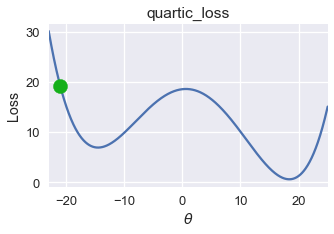

In [5]:
pts = np.array([0])
plot_loss(pts, (-23, 25), quartic_loss)
plot_theta_on_loss(pts, -21, quartic_loss)

old theta: -21
new theta: -9.944999999999999


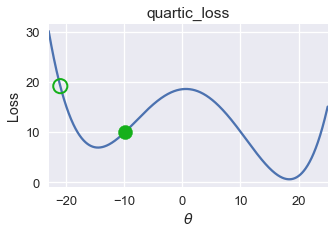

In [6]:
plot_one_gd_iter(pts, -21, quartic_loss, grad_quartic_loss)

old theta: -9.9
new theta: -12.641412


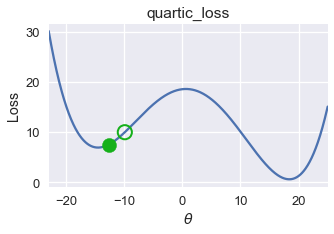

In [7]:
plot_one_gd_iter(pts, -9.9, quartic_loss, grad_quartic_loss)

old theta: -12.6
new theta: -14.162808


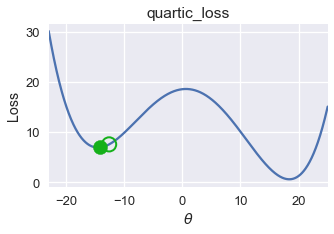

In [8]:
plot_one_gd_iter(pts, -12.6, quartic_loss, grad_quartic_loss)

old theta: -14.2
new theta: -14.497463999999999


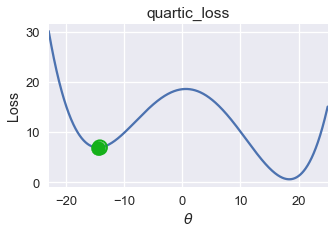

In [9]:
plot_one_gd_iter(pts, -14.2, quartic_loss, grad_quartic_loss)

On this loss function and $ \theta $ value, gradient descent converges to $ \theta = -14.5 $, producing a loss of roughly 8. However, the global minimum for this loss function is $ \theta = 18 $, corresponding to a loss of nearly zero. From this example, we observe that gradient descent finds a *local minimum* which may not necessarily have the same loss as the *global minimum*.

Luckily, a number of useful loss functions have identical local and global minima. Consider the familiar mean squared error loss function, for example:

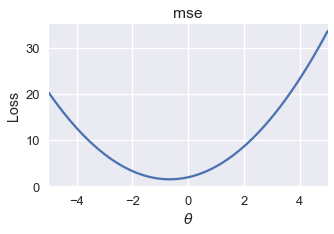

In [10]:
pts = np.array([-2, -1, 1])
plot_loss(pts, (-5, 5), mse)

Running gradient descent on this loss function with an appropriate learning rate will always find the globally optimal $ \theta $ since the sole local minimum is also the global minimum.

The mean absolute error sometimes has multiple local minima. However, all the local minima produce the globally lowest loss possible.

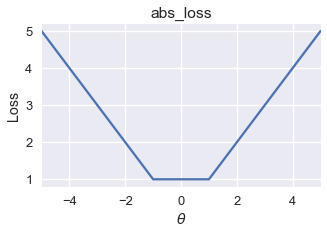

In [11]:
pts = np.array([-1, 1])
plot_loss(pts, (-5, 5), abs_loss)

On this loss function, gradient descent will converge to one of the local minima in the range $ [-1, 1] $. Since all of these local minima have the lowest loss possible for this function, gradient descent will still return an optimal choice of $ \theta $.

## Definition of Convexity

For some functions, any local minimum is also a global minimum. This set of functions are called **convex functions** since they curve upward. For a constant model, the MSE, MAE, and Huber loss are all convex.

With an appropriate learning rate, gradient descent finds the globally optimal $\theta$ for convex loss functions. Because of this useful property, we prefer to fit our models using convex loss functions unless we have a good reason not to.

Formally, a function $f$ is convex if and only if it satisfies the following inequality for all possible function inputs $a$ and $b$, for all $t \in [0, 1]$:

$$tf(a) + (1-t)f(b) \geq f(ta + (1-t)b)$$

This inequality states that all lines connecting two points of the function must reside on or above the function itself. For the loss function at the start of the section, we can easily find such a line that appears below the graph:

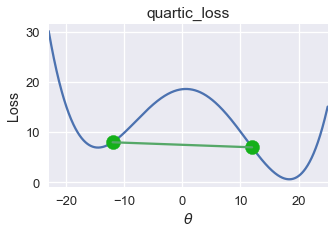

In [12]:
pts = np.array([0])
plot_loss(pts, (-23, 25), quartic_loss)
plot_connected_thetas(pts, -12, 12, quartic_loss)

Thus, this loss function is non-convex.

For MSE, all lines connecting two points of the graph appear above the graph. We plot one such line below.

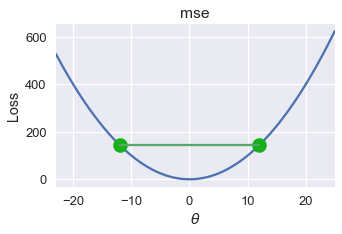

In [13]:
pts = np.array([0])
plot_loss(pts, (-23, 25), mse)
plot_connected_thetas(pts, -12, 12, mse)

The mathematical definition of convexity gives us a precise way of determining whether a function is convex. In this textbook, we will omit mathematical proofs of convexity and will instead state whether a chosen loss function is convex.

## Summary

For a convex function, any local minimum is also a global minimum. This useful property allows gradient descent to efficiently find the globally optimal model parameters for a given loss function. While gradient descent will converge to a local minimum for non-convex loss functions, these local minima are not guaranteed to be globally optimal.